In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization
from g_media_pipe import extract_data_from_video, save_data
import ast
import glob
import os

In [2]:
directory = os.path.join("model_data")
csv_files = glob.glob(os.path.join(directory,"Squats","Proper","*.csv"))

In [3]:
csv_files

['model_data\\Squats\\Proper\\properSquat1.csv',
 'model_data\\Squats\\Proper\\ProperSquat10.csv',
 'model_data\\Squats\\Proper\\ProperSquat3.csv',
 'model_data\\Squats\\Proper\\ProperSquat4.csv',
 'model_data\\Squats\\Proper\\ProperSquat5.csv',
 'model_data\\Squats\\Proper\\ProperSquat6.csv',
 'model_data\\Squats\\Proper\\ProperSquat7.csv',
 'model_data\\Squats\\Proper\\ProperSquat8.csv',
 'model_data\\Squats\\Proper\\ProperSquat9.csv',
 'model_data\\Squats\\Proper\\Proper_Squat_1.csv']

In [5]:
class VideoProcessingPipeline: 
    """
    Class for identifying the number of squats done in a .mp4 video
    """
    def __init__(self,video_file_path:str,threshold:float = 0.25) -> None:
        self.threshold = threshold
        raw_data = extract_data_from_video(video_path=video_file_path)
        df = pd.DataFrame(raw_data).drop(['NOSE', 'LEFT_EYE_INNER', 'LEFT_EYE', 'LEFT_EYE_OUTER',
       'RIGHT_EYE_INNER', 'RIGHT_EYE', 'RIGHT_EYE_OUTER', 'LEFT_EAR',
       'RIGHT_EAR', 'MOUTH_LEFT', 'MOUTH_RIGHT', 'LEFT_SHOULDER',
       'RIGHT_SHOULDER', 'LEFT_ELBOW', 'RIGHT_ELBOW', 'LEFT_WRIST',
       'RIGHT_WRIST', 'LEFT_PINKY', 'RIGHT_PINKY', 'LEFT_INDEX', 'RIGHT_INDEX','LEFT_THUMB', 'RIGHT_THUMB','LEFT_ANKLE', 'RIGHT_ANKLE', 'LEFT_HEEL', 'RIGHT_HEEL',
       'LEFT_FOOT_INDEX', 'RIGHT_FOOT_INDEX'],axis=1)
        processed_df = self.process_df(df)
        for col in processed_df.columns:
            processed_df[col] = self.smooth_gaussian(self.min_max_scaler(processed_df[col]))
        self.data = processed_df
        
    def process_df(self,data:pd.DataFrame) -> pd.DataFrame:
        if isinstance(data.iloc[0][0],str):
            data = data.map(ast.literal_eval)

        x_coors = data.map(lambda coords: coords[0])  # Get the X coordinates
        y_coors = data.map(lambda coords: coords[1])  # Get the Y coordinates
        z_coors = data.map(lambda coords: coords[2])  # Get the Z coordinates

        # If you want to combine these into a single DataFrame with columns like NOSE_x, NOSE_y, NOSE_z, etc.
        x_coors.columns = [f'{col}_x' for col in x_coors.columns]
        y_coors.columns = [f'{col}_y' for col in y_coors.columns]
        z_coors.columns = [f'{col}_z' for col in z_coors.columns]
        # Combine the x, y, z data into a single DataFrame
        return pd.concat([x_coors, y_coors, z_coors], axis=1)
    
    def min_max_scaler(self,col:pd.Series)->pd.Series:
        min_value = np.min(col)
        max_value = np.max(col)
        return col.map(lambda x: (x-min_value)/(max_value-min_value))
    
    def smooth_gaussian(self,data:pd.Series, sigma=2)->pd.Series:
        """
        Smoothen the curves using a Gaussian filter.

        Parameters:
        - data: NumPy array, the input signal to smooth.
        - sigma: Standard deviation of the Gaussian kernel.

        Returns:
        - smoothed_data: NumPy array of the smoothed data.
        """
        kernel_radius = int(3 * sigma)  # 3 standard deviations cover ~99% of data
        x = np.arange(-kernel_radius, kernel_radius + 1)
        gaussian_kernel = np.exp(-x**2 / (2 * sigma**2))
        gaussian_kernel /= gaussian_kernel.sum()  # Normalize the kernel
        
        # Padding to avoid edge effects
        padded_data = np.pad(data, pad_width=kernel_radius, mode='edge')
        
        # Convolution with Gaussian kernel
        smoothed_data = np.convolve(padded_data, gaussian_kernel, mode='valid')
        
        return smoothed_data
    
    def count_reps(self):
        left_knee_count = right_knee_count = 0
        right_knee_col = self.data['RIGHT_KNEE_z']
        left_knee_col = self.data['LEFT_KNEE_z']
        for i in range(len(right_knee_col)-1):
            if right_knee_col[i] > self.threshold and right_knee_col[i+1] <= self.threshold:
                right_knee_count += 1
            if left_knee_col[i] > self.threshold and left_knee_col[i+1] <= self.threshold:
                left_knee_count += 1
        return (left_knee_count,right_knee_count)

In [8]:
# read a new mp4 file and count the number of reps
#pipeline = VideoProcessingPipeline(r"D:\NirwanaWarehouse\uniWork\Term 7\Capstone\backend\FITTR_WEBSOCKET\datasets\Test\Exercise Library_ Squats_8_reps.mp4")
#save_data(videoData=video_data,output_path=r"D:\NirwanaWarehouse\uniWork\Term 7\Capstone\backend\datasets\Test\Squats_8_reps.csv")
# pipeline = extract_data_from_video()
# pipeline = pd.DataFrame.from_dict(pipeline)
# pipeline.head()

Extracting data from video file: D:\NirwanaWarehouse\uniWork\Term 7\Capstone\backend\FITTR_WEBSOCKET\datasets\Bicep_Curls\dumbellFront.mp4


d:\Anaconda\envs\capstone\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


,NOSE,LEFT_EYE_INNER,LEFT_EYE,LEFT_EYE_OUTER,RIGHT_EYE_INNER,RIGHT_EYE,RIGHT_EYE_OUTER,LEFT_EAR,RIGHT_EAR,MOUTH_LEFT,...,LEFT_HIP,RIGHT_HIP,LEFT_KNEE,RIGHT_KNEE,LEFT_ANKLE,RIGHT_ANKLE,LEFT_HEEL,RIGHT_HEEL,LEFT_FOOT_INDEX,RIGHT_FOOT_INDEX
0,"[0.6467066407203674, 0.21014460921287537, -0.4...","[0.6731221675872803, 0.18747949600219727, -0.4...","[0.6883413195610046, 0.18707630038261414, -0.4...","[0.6988475322723389, 0.18708211183547974, -0.4...","[0.6297277808189392, 0.18866649270057678, -0.4...","[0.6167898178100586, 0.188909113407135, -0.441...","[0.6088284254074097, 0.18931809067726135, -0.4...","[0.7206753492355347, 0.19570699334144592, -0.2...","[0.599930465221405, 0.19730526208877563, -0.18...","[0.6761810183525085, 0.23090258240699768, -0.3...",...,"[0.7112531065940857, 0.5809341073036194, 0.009...","[0.531732976436615, 0.571425199508667, -0.0092...","[0.7070174217224121, 0.7692223191261292, 0.017...","[0.4869254529476166, 0.7779607176780701, 0.046...","[0.6830869317054749, 0.9117525219917297, 0.483...","[0.46600914001464844, 0.918861985206604, 0.432...","[0.6585888266563416, 0.9244510531425476, 0.516...","[0.4852937161922455, 0.9294676780700684, 0.460...","[0.6995294094085693, 0.982068657875061, 0.2747...","[0.4352160692214966, 0.9859894514083862, 0.201..."
1,"[0.6518204808235168, 0.21016864478588104, -0.6...","[0.6768769025802612, 0.18784405291080475, -0.6...","[0.6926479935646057, 0.18776780366897583, -0.6...","[0.7052485942840576, 0.18806768953800201, -0.6...","[0.6312695145606995, 0.18865425884723663, -0.6...","[0.6186068654060364, 0.18884199857711792, -0.6...","[0.6095898747444153, 0.1892312616109848, -0.66...","[0.723345160484314, 0.1962822675704956, -0.432...","[0.5998901128768921, 0.1971122771501541, -0.37...","[0.6799886226654053, 0.231657937169075, -0.602...",...,"[0.7113085389137268, 0.5900956988334656, 0.008...","[0.5312215685844421, 0.5770431756973267, -0.00...","[0.7070239782333374, 0.7839080691337585, 0.063...","[0.48669853806495667, 0.7795645594596863, 0.16...","[0.6831883192062378, 0.924730658531189, 0.6328...","[0.46603354811668396, 0.918300449848175, 0.702...","[0.658591091632843, 0.9392210245132446, 0.6743...","[0.48526832461357117, 0.9294716119766235, 0.74...","[0.6996629238128662, 0.9918864965438843, 0.410...","[0.43161091208457947, 0.9862264394760132, 0.47..."
2,"[0.6548553109169006, 0.2114051878452301, -0.74...","[0.6795600652694702, 0.18982037901878357, -0.7...","[0.6957402229309082, 0.19014227390289307, -0.7...","[0.7088101506233215, 0.1905321180820465, -0.71...","[0.6332051753997803, 0.18972787261009216, -0.7...","[0.6204051375389099, 0.18968990445137024, -0.7...","[0.6106896996498108, 0.1899159848690033, -0.70...","[0.7262998223304749, 0.1980966031551361, -0.46...","[0.6002998948097229, 0.19736483693122864, -0.4...","[0.6824803948402405, 0.23348574340343475, -0.6...",...,"[0.7118335962295532, 0.5962700843811035, 0.008...","[0.5310061573982239, 0.582129180431366, -0.008...","[0.7071384191513062, 0.7870427966117859, 0.095...","[0.48671403527259827, 0.7824338674545288, 0.18...","[0.6831373572349548, 0.9254366159439087, 0.686...","[0.46601513028144836, 0.9173147082328796, 0.73...","[0.6581169366836548, 0.9416084289550781, 0.730...","[0.48486873507499695, 0.9292594194412231, 0.77...","[0.6996698975563049, 0.9935105443000793, 0.469...","[0.4294135570526123, 0.986746609210968, 0.5079..."
3,"[0.6569365859031677, 0.21329590678215027, -0.7...","[0.6818781495094299, 0.19217821955680847, -0.7...","[0.6982638835906982, 0.19265992939472198, -0.7...","[0.7112597823143005, 0.19294103980064392, -0.7...","[0.6351597905158997, 0.191401869058609, -0.737...","[0.6221935153007507, 0.1912510097026825, -0.73...","[0.612635612487793, 0.1914030909538269, -0.737...","[0.7292462587356567, 0.19973960518836975, -0.5...","[0.6015849709510803, 0.19788695871829987, -0.4...","[0.6838749647140503, 0.23552048206329346, -0.6...",...,"[0.7122469544410706, 0.5953993797302246, 0.008...","[0.5309701561927795, 0.5821197032928467, -0.0

In [12]:
def euclidean(joint1,joint2):
        joint1 = eval(joint1)
        joint2 = eval(joint2)
        xi,yi,zi = joint1
        xj,yj,zj = joint2
        return (np.square(xi-xj)+np.square(yi-yj)+np.square(zi-zj))**0.5

def calculate_joint_angle(a,b,c):
    """
    Computes 3D joint angle inferred by 3 keypoints and their relative positions to one another
    
    """
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 

def smooth_gaussian(data:pd.Series, sigma=2)->pd.Series:
    """
    Smoothen the curves using a Gaussian filter.
    Parameters:
    - data: NumPy array, the input signal to smooth.
    - sigma: Standard deviation of the Gaussian kernel.
    Returns:
    - smoothed_data: NumPy array of the smoothed data.
    """
    kernel_radius = int(3 * sigma)  # 3 standard deviations cover ~99% of data
    x = np.arange(-kernel_radius, kernel_radius + 1)
    gaussian_kernel = np.exp(-x**2 / (2 * sigma**2))
    gaussian_kernel /= gaussian_kernel.sum()  # Normalize the kernel
    
    # Padding to avoid edge effects
    padded_data = np.pad(data, pad_width=kernel_radius, mode='edge')
    
    # Convolution with Gaussian kernel
    smoothed_data = np.convolve(padded_data, gaussian_kernel, mode='valid')
    
    return pd.Series(smoothed_data,index=data.index)

def calculate_angle(joint_a, joint_b, joint_c):
    """
    Calculate the angle between three joints in 3D space using numpy.
    
    Args:
    joint_a (tuple): The (x, y, z) coordinates of the first joint.
    joint_b (tuple): The (x, y, z) coordinates of the second joint (vertex joint).
    joint_c (tuple): The (x, y, z) coordinates of the third joint.
    
    Returns:
    float: The angle in degrees between the three joints.
    """
    # Convert joint coordinates to numpy arrays
    joint_a = np.array(joint_a, dtype=float)
    joint_b = np.array(joint_b, dtype=float)
    joint_c = np.array(joint_c, dtype=float)


    # Calculate vectors: Joint A to B and Joint B to C
    vector_ab = joint_b - joint_a
    vector_bc = joint_c - joint_b
    
    # Calculate dot product and magnitudes using numpy
    dot_product = np.dot(vector_ab, vector_bc)
    magnitude_ab = np.linalg.norm(vector_ab)
    magnitude_bc = np.linalg.norm(vector_bc)
    
    # Avoid division by zero by ensuring valid magnitude values
    if magnitude_ab == 0 or magnitude_bc == 0:
        raise ValueError("One of the vectors has zero length, can't calculate angle.")
    
    # Calculate the cosine of the angle
    cos_theta = dot_product / (magnitude_ab * magnitude_bc)
    
    # Ensure cos_theta is within [-1, 1] to avoid domain errors
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    
    # Calculate the angle in radians, then convert to degrees
    angle_rad = np.arccos(cos_theta)
    angle_deg = np.degrees(angle_rad)
    
    return angle_deg

def joint_angles_per_record(record, joints):
    """
    Calculate the joint angle for a single record (pd.Series).
    
    Args:
    record (pd.Series): A single row from a DataFrame containing joint positions.
    joints (list): List of three joint names as strings (column names).
    
    Returns:
    float: The calculated angle for the given joints in the record.
    """
    joint_a, joint_b, joint_c = joints

    # Extract joint coordinates directly from the record
    a_coords = record[joint_a]
    b_coords = record[joint_b]
    c_coords = record[joint_c]
    
    # Convert string of coordinates to tuple (x, y, z) if necessary
    if isinstance(a_coords, (list, tuple)):
        pass  # already in (x, y, z) format
    if isinstance(a_coords,str):
        a_coords = ast.literal_eval(a_coords)
        b_coords = ast.literal_eval(b_coords)
        c_coords = ast.literal_eval(c_coords)
    else:
        a_coords = tuple(a_coords)
        b_coords = tuple(b_coords)
        c_coords = tuple(c_coords)
    # Calculate the angle between the joints
    angle = calculate_angle(a_coords, b_coords, c_coords)
    
    return angle

def plot_joint_angles(df, joints, angle_name="Angle"):
    """
    Calculate and plot joint angles over time.

    Args:
    df (pd.DataFrame): DataFrame containing joint positions for each timeframe.
    joints (list): List of three joints as tuples of (x, y, z) columns.
    angle_name (str): Name for the angle being calculated.
    """
    joint_a, joint_b, joint_c = joints
    
    # Initialize an empty list to store the angles
    angles = []
    
    # Iterate over each row (timeframe) in the DataFrame
    for _, row in df.iterrows():
        # Extract joint coordinates
        a_coords = row[joint_a]
        b_coords = row[joint_b]
        c_coords = row[joint_c]
        if isinstance(a_coords,str):
            a_coords = ast.literal_eval(a_coords)
            b_coords = ast.literal_eval(b_coords)
            c_coords = ast.literal_eval(c_coords)
        # Calculate angle and append to list
        angle = calculate_angle(a_coords, b_coords, c_coords)
        angles.append(angle)
    angles = smooth_gaussian(pd.Series(angles))
    
    # Plot the angles over time
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, angles, label=f'{angle_name}')
    plt.xlabel("Timeframe")
    plt.ylabel("Angle (degrees)")
    plt.title(f'{angle_name} Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

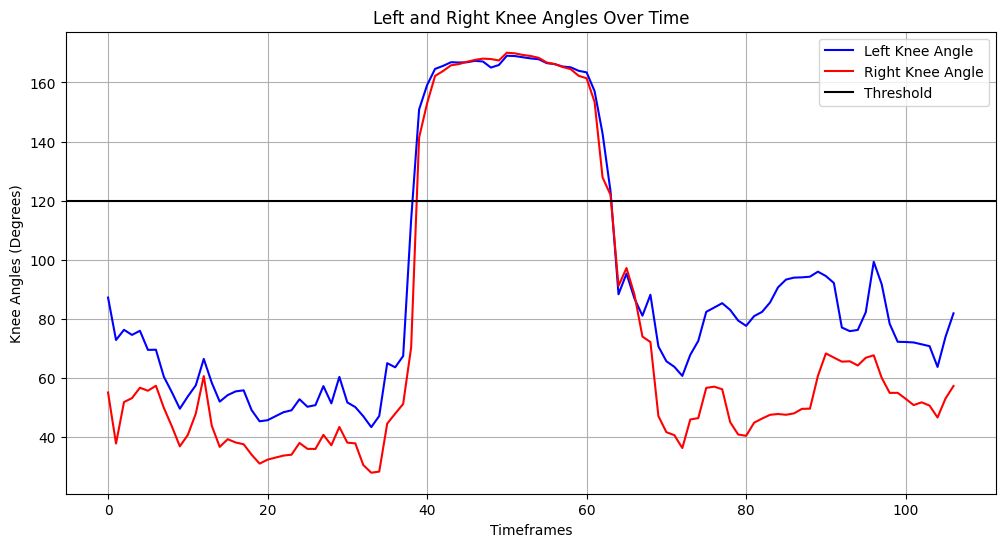

In [8]:
pipeline = pd.read_csv(csv_files[0])
left_angles = []
right_angles = []
left_knee_angle_joints = ("LEFT_HIP", "LEFT_KNEE", "LEFT_ANKLE")
right_knee_angle_joints = ("RIGHT_HIP", "RIGHT_KNEE", "RIGHT_ANKLE")
for _,row in pipeline.iterrows():
    left_angles.append(joint_angles_per_record(row,left_knee_angle_joints))
    right_angles.append(joint_angles_per_record(row,right_knee_angle_joints))

# Assuming `left_angles` and `right_angles` are already populated
plt.figure(figsize=(12, 6))  # Set the figure size

# Plot left angles
plt.plot(left_angles, label="Left Knee Angle", color='blue')

# Plot right angles
plt.plot(right_angles, label="Right Knee Angle", color='red')
plt.axhline(120,label='Threshold',color='black')
# Add axis labels and legend
plt.xlabel("Timeframes")
plt.ylabel("Knee Angles (Degrees)")
plt.title("Left and Right Knee Angles Over Time")
plt.legend()  # Show legend for both lines
plt.grid(True)  # Add a grid for better readability

# Display the plot
plt.show()


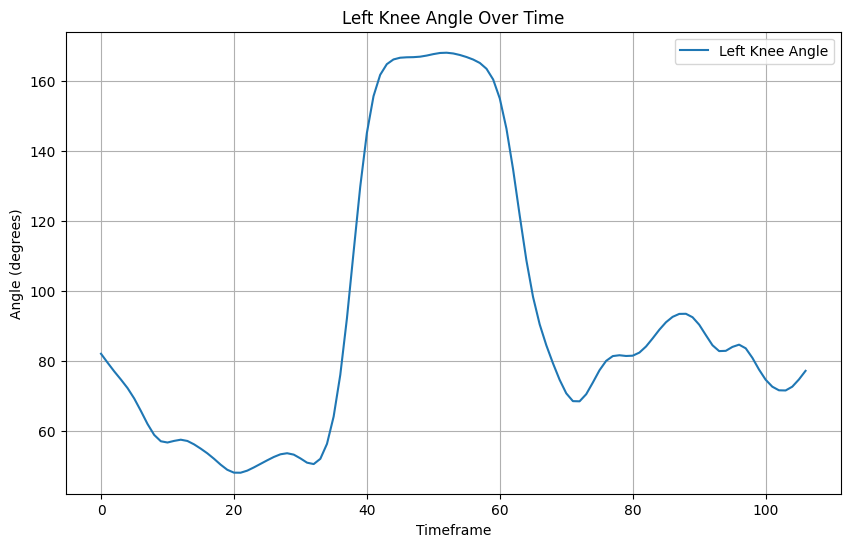

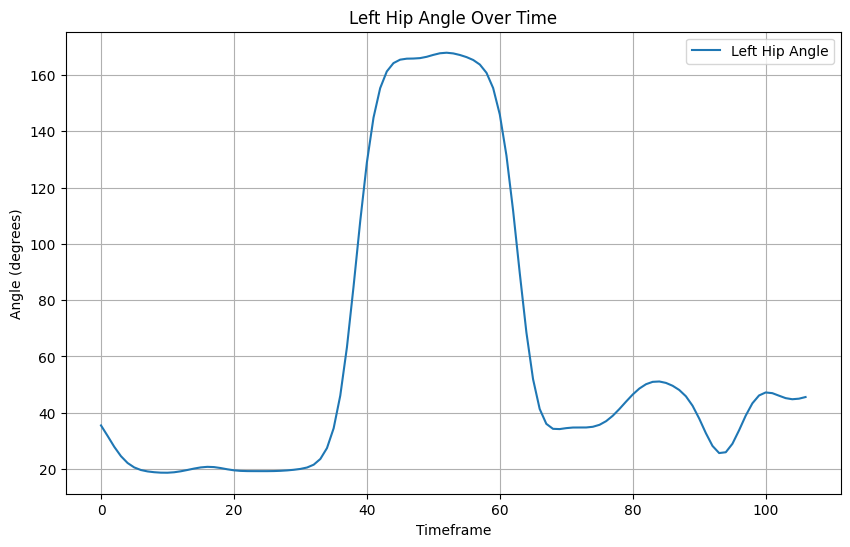

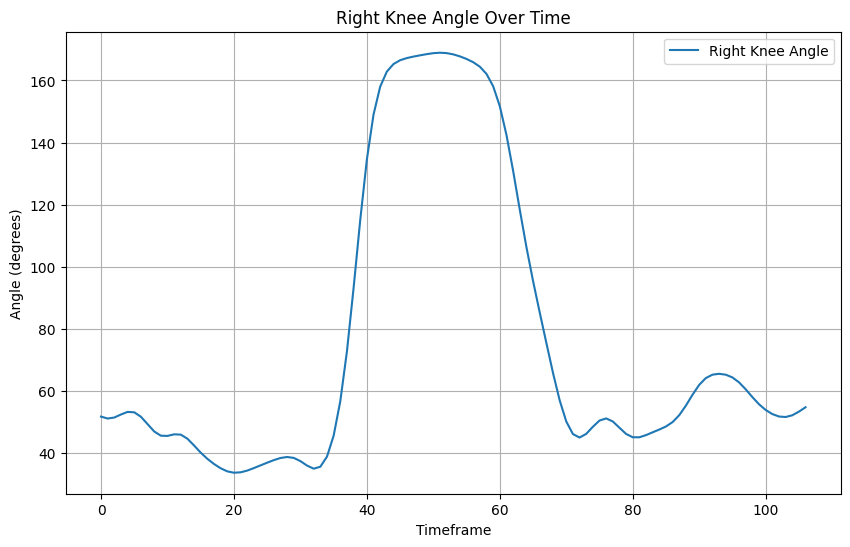

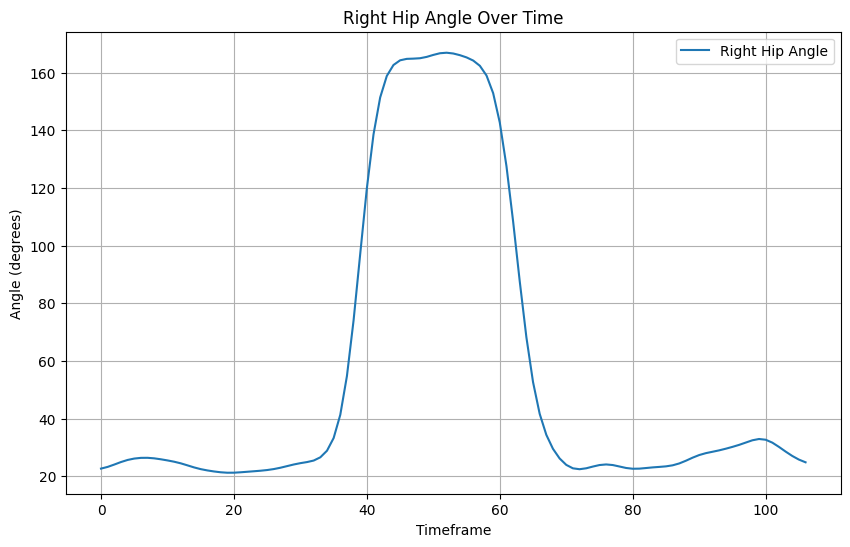

In [11]:
df = pipeline.copy()
# Define joint groups for left side (similar logic applies to right side)
left_knee_angle_joints = ("LEFT_HIP", "LEFT_KNEE", "LEFT_ANKLE")
left_hip_angle_joints = ("LEFT_SHOULDER", "LEFT_HIP", "LEFT_KNEE")
#left_ankle_angle_joints = ("LEFT_KNEE", "LEFT_ANKLE", "LEFT_FOOT_INDEX")

right_knee_angle_joints = ("RIGHT_HIP", "RIGHT_KNEE", "RIGHT_ANKLE")
right_hip_angle_joints = ("RIGHT_SHOULDER", "RIGHT_HIP", "RIGHT_KNEE")
#right_ankle_angle_joints = ("RIGHT_KNEE", "RIGHT_ANKLE", "RIGHT_FOOT_INDEX")

# Example of plotting angles for different joints for a squat motion
plot_joint_angles(df, left_knee_angle_joints, "Left Knee Angle")
plot_joint_angles(df, left_hip_angle_joints, "Left Hip Angle")
#plot_joint_angles(df, left_ankle_angle_joints, "Left Ankle Angle")

plot_joint_angles(df, right_knee_angle_joints, "Right Knee Angle")
plot_joint_angles(df, right_hip_angle_joints, "Right Hip Angle")
#plot_joint_angles(df, right_ankle_angle_joints, "Right Ankle Angle")


In [78]:
pipeline = VideoProcessingPipeline(r"D:\NirwanaWarehouse\uniWork\Term 7\Capstone\backend\FITTR_WEBSOCKET\datasets\Test\Exercise Library_ Squats_8_reps.mp4")

Extracting data from video file: D:\NirwanaWarehouse\uniWork\Term 7\Capstone\backend\FITTR_WEBSOCKET\datasets\Test\Exercise Library_ Squats_8_reps.mp4


d:\Anaconda\envs\capstone\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
C:\Users\saran\AppData\Local\Temp\ipykernel_27744\1929455758.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(data.iloc[0][0],str):


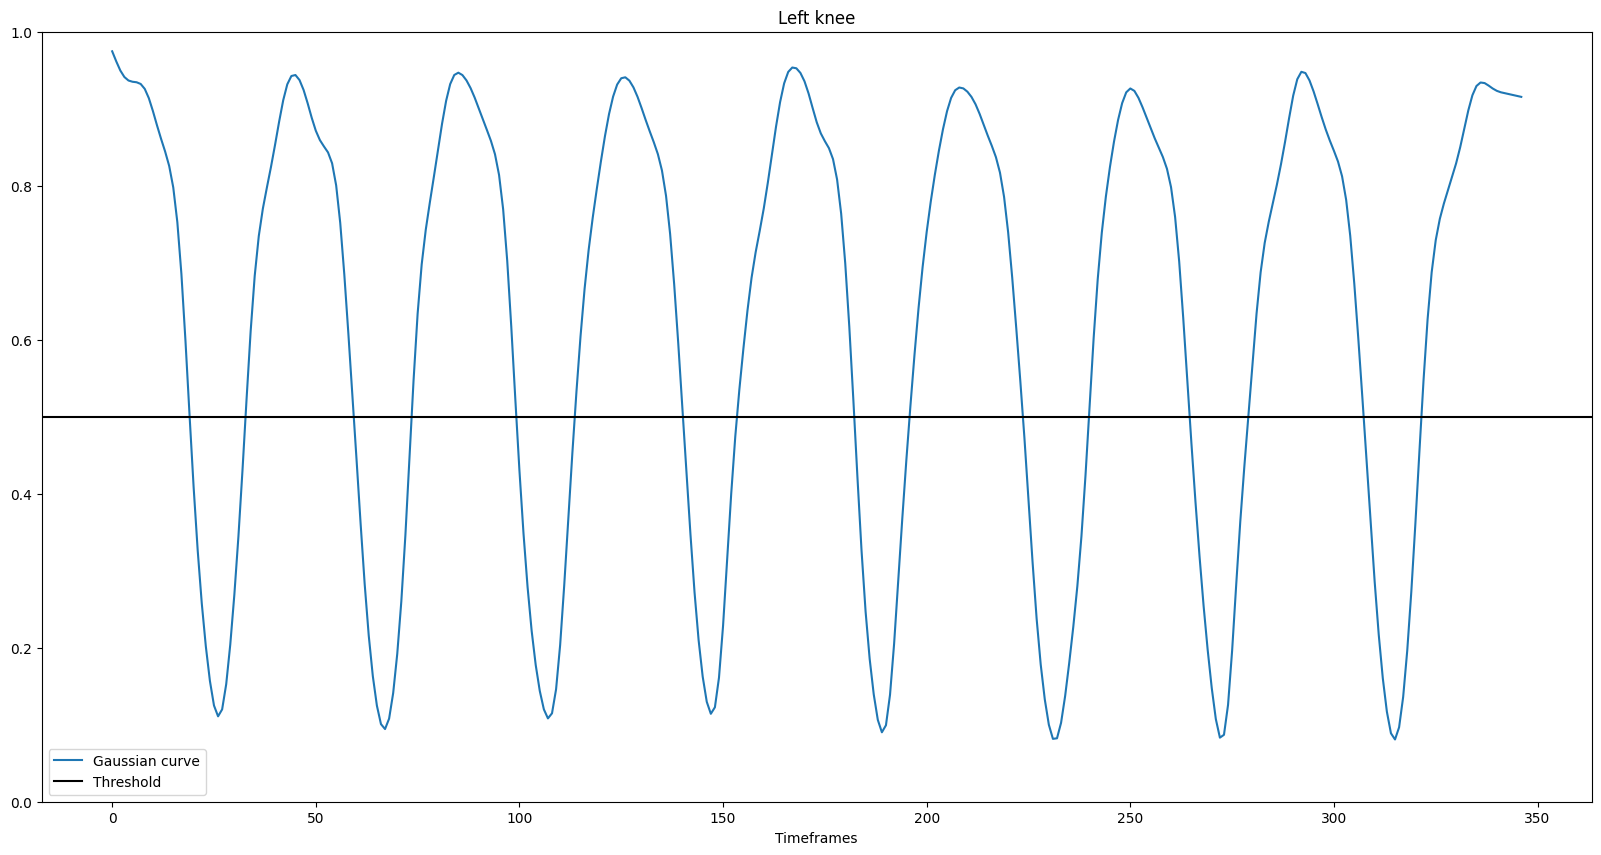

In [85]:
plt.figure(figsize=(20, 10))
plt.plot(pipeline.data['LEFT_KNEE_z'],label='Gaussian curve')
plt.title("Left knee")
plt.xlabel("Timeframes")
plt.axhline(0.5,label='Threshold',color='black')
plt.ylim((0,1))
plt.legend()

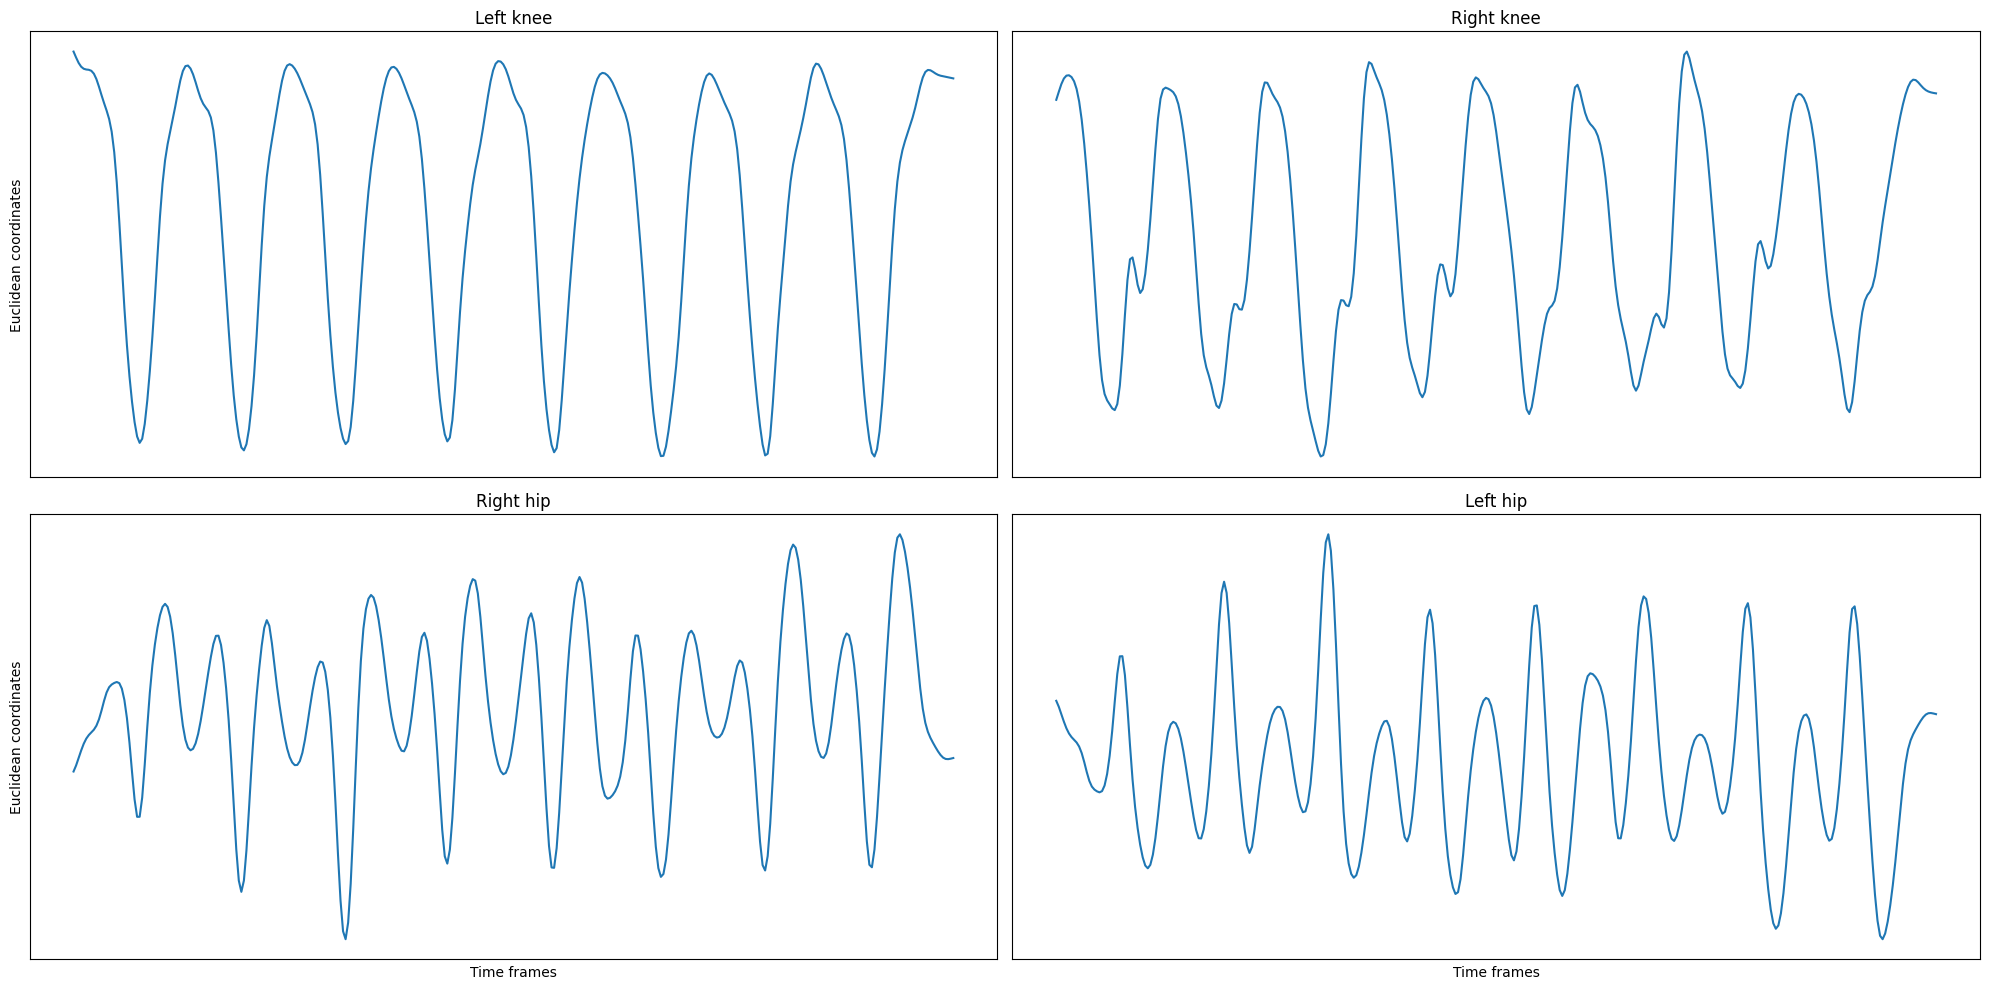

In [11]:
plt.figure(figsize=(20, 10))

# First row, first plot: LEFT_KNEE_z
plt.subplot(221)
plt.plot(pipeline.data['LEFT_KNEE_z'])
plt.title('Left knee')
plt.xticks([]), plt.yticks([])
plt.ylabel("Euclidean coordinates")

# First row, second plot: RIGHT_KNEE_z
plt.subplot(222)
plt.plot(pipeline.data['RIGHT_KNEE_z'])
plt.title('Right knee')
plt.xticks([]), plt.yticks([])

# Second row, first plot: RIGHT_HIP_z
plt.subplot(223)
plt.plot(pipeline.data['RIGHT_HIP_z'])
plt.title('Right hip')
plt.xticks([]), plt.yticks([])
plt.xlabel("Time frames")
plt.ylabel("Euclidean coordinates")

# Second row, second plot: LEFT_HIP_z
plt.subplot(224)
plt.plot(pipeline.data['LEFT_HIP_z'])
plt.title('Left hip')
plt.xticks([]), plt.yticks([])
plt.xlabel("Time frames")

plt.tight_layout()
plt.show()


In [55]:
df_test = pd.read_csv(r"D:\NirwanaWarehouse\uniWork\Term 7\Capstone\backend\live_stream_test2.csv")
df_test.head()

,LEFT_HIP_x,RIGHT_HIP_x,LEFT_KNEE_x,RIGHT_KNEE_x,LEFT_HIP_y,RIGHT_HIP_y,LEFT_KNEE_y,RIGHT_KNEE_y,LEFT_HIP_z,RIGHT_HIP_z,LEFT_KNEE_z,RIGHT_KNEE_z
0,0.367449,0.367978,0.369028,0.370651,0.372835,0.375256,0.377831,0.380374,0.382670,0.384382,0.385463,0.386127
1,0.363202,0.363729,0.364776,0.366415,0.368610,0.371048,0.373642,0.376202,0.378524,0.380243,0.381330,0.381995
2,0.350156,0.350663,0.351681,0.353332,0.355520,0.357952,0.360543,0.363103,0.365455,0.367160,0.368236,0.368890
3,0.342797,0.343299,0.344330,0.346022,0.348261,0.350753,0.353407,0.356035,0.358459,0.360202,0.361294,0.361962
4,0.337202,0.337702,0.338698,0.340420,0.342657,0.345151,0.347810,0.350437,0.352904,0.354625,0.355718,0.356381


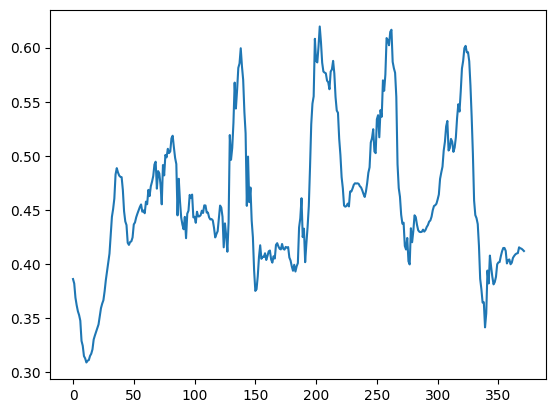

In [57]:
plt.plot(df_test["RIGHT_KNEE_z"])

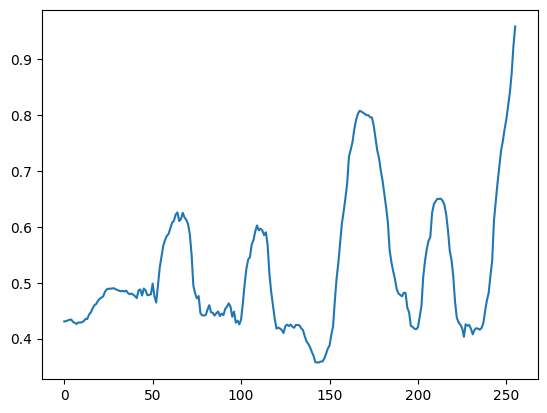

In [29]:
plt.plot(df_test["RIGHT_KNEE_z"])